In [65]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt

## Data Preparation

In [2]:

input_file_path = Path('../data/tinyshakespeare.txt')

with open(input_file_path, 'r') as f:
    text = f.read()
print(f"length of dataset in characters: {len(text):,}")


length of dataset in characters: 1,115,393


#### get all the unique characters that occur in this text


In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


#### create a mapping from characters to integers


In [4]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(f"{encode("khoa") = }")
print(f"{decode(encode("khoa")) = }")

encode("khoa") = [49, 46, 53, 39]
decode(encode("khoa")) = 'khoa'


In [5]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.type)
print(data[:100])

torch.Size([1115393]) <built-in method type of Tensor object at 0x7c74a8195900>
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


So, we have a very small code book of 65 characters, very simple `encode` and `decode` functions, but we get very long sequences as a result

#### create the train and validation splits

In [6]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [7]:
print(f"{train_data.shape = }")
print(f"{val_data.shape = }")

train_data.shape = torch.Size([1003853])
val_data.shape = torch.Size([111540])


In [8]:
block_size = 8
train_data[:block_size]

tensor([18, 47, 56, 57, 58,  1, 15, 47])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context}, target = {target}")

when input is tensor([18]), target = 47
when input is tensor([18, 47]), target = 56
when input is tensor([18, 47, 56]), target = 57
when input is tensor([18, 47, 56, 57]), target = 58
when input is tensor([18, 47, 56, 57, 58]), target = 1
when input is tensor([18, 47, 56, 57, 58,  1]), target = 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]), target = 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), target = 58


> **Training Notes**:  
>
> We will train on all 8 input examples with the context of 1 character upto 8 characters. This is not just because of computational reasons, but also to make our Transformer get used to see inputs of different sizes (upto block size characters).  
>
> We will stack many batches of multiple chunks of text in a single torch `Tensor`, so we can keep the GPU busy since it is very good at parallel processing of data. These chunks will be processed independently in a parallel manner

In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # randomizing the training data 
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


print('---- getting the first batch of data ----')
xb, yb = get_batch('train')

print('inputs:')
print(f"{xb.shape = }")
print(f"{xb = }")
print()

print('targets:')
print(f"{yb.shape = }")
print(f"{yb = }")
print()

print(f'---- there are {batch_size*block_size} training examples here ----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

---- getting the first batch of data ----
inputs:
xb.shape = torch.Size([4, 8])
xb = tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])

targets:
yb.shape = torch.Size([4, 8])
yb = tensor([[59,  6,  1, 58, 56, 47, 40, 59],
        [43, 43, 54,  1, 47, 58,  1, 58],
        [52, 45, 43, 50, 53,  8,  0, 26],
        [39,  1, 46, 53, 59, 57, 43,  0]])

---- there are 32 training examples here ----
when input is [53] the target: 59
when input is [53, 59] the target: 6
when input is [53, 59, 6] the target: 1
when input is [53, 59, 6, 1] the target: 58
when input is [53, 59, 6, 1, 58] the target: 56
when input is [53, 59, 6, 1, 58, 56] the target: 47
when input is [53, 59, 6, 1, 58, 56, 47] the target: 40
when input is [53, 59, 6, 1, 58, 56, 47, 40] the target: 59
when input is [49] the target: 43
when input is [49, 43] the target: 43
when input is [49, 43, 43] the target: 54


## Baseline Bigram Language Model

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None) -> tuple[torch.Tensor, torch.Tensor | None]:
        logits = self.token_embedding_table(idx)  # (batch, time, channel)
        # F.cross_entropy expects logits.shape to be [batch_size, num_classes] 
        # and targets to be of shape [batch_size],
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)  # e.g. [32, 65]
            targets = targets.view(B*T)  # e.g. [32]
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the loss and predictions
            logits, loss = self(idx)
            # focus only on the last time step in the logits
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
out

(tensor([[-0.3724, -0.2800, -0.0915,  ...,  0.8662, -0.9581, -0.9197],
         [-1.2796,  0.3641, -0.8859,  ...,  0.5602,  0.6467,  0.6577],
         [ 0.4138, -1.4386,  1.2962,  ...,  1.6742, -0.2397,  0.3415],
         ...,
         [-1.2796,  0.3641, -0.8859,  ...,  0.5602,  0.6467,  0.6577],
         [ 0.7763, -0.8460,  0.8437,  ..., -1.0367, -1.2909,  1.1822],
         [ 0.3418, -0.9276,  1.2381,  ...,  1.5018, -0.5266,  0.2354]],
        grad_fn=<ViewBackward0>),
 tensor(4.9456, grad_fn=<NllLossBackward0>))

In [12]:
idx = torch.zeros((1, 1), dtype=torch.long)
decode(m.generate(idx, max_new_tokens=100)[0].tolist())

"\nl-QYjt'CL?jLDuQcLzy'RIo;'KdhpV\nvLixa,nswYZwLEPS'ptIZqOZJ$CA$zy-QTkeMk x.gQSFCLg!iW3fO!3DGXAqTsq3pdgq"

### Train the model

In [13]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

/home/dk/miniconda3/envs/rupygpt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
batch_size = 32
for steps in range(1000): # increase number of steps for good results...
    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)  # set gradients to 0
    loss.backward()  # getting new gradients for all the weights
    optimizer.step()  # use the gradients to update the weights

print(loss.item())


3.744039535522461


In [15]:
idx = torch.zeros((1, 1), dtype=torch.long)
decode(m.generate(idx, max_new_tokens=100)[0].tolist())

"\nN3vVoesMyas:Iocindad.e-NNSqYPso&bFho&$;BQ$dZTMf'mKlf;DRPm'W,esPzyXAzCA$;GunqCEy&Oy;ZxjKVhmrdhxCAbTSp"

## Building the "Self-Attention"

First, let's prepare the inputs 

In [16]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch size, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

### Attention V1: averaging past context with `for` loops, the weakest form of aggregation

In [17]:
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        # the previous tokens are from 0 up to this current token including it 
        xprev = x[b, :t+1]  # shape: (t, C)
        xbow[b, t] = torch.mean(xprev, 0)

In [33]:
x

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])

In [32]:
xbow

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

*This is ok but very inefficient. Let's do the same thing but with matrix multiplication for better performance*

### Attention V2: Using matrix multiply as weighted aggregation


In [18]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)  # do this to get the average of the columns in b 
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [19]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)  # wei is `a` above
print(f"{wei = }")
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)

wei = tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [21]:
torch.allclose(xbow, xbow2)

False

In [23]:
torch.sum(xbow - xbow2)

tensor(1.3947e-07)

### Attention V3: Using softmax - More Intuitive 


In [25]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [46]:
wei = torch.zeros(T, T)
wei = wei.masked_fill(tril == 0, float('-inf'))  # masking future tokens' afinities to be 0s
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

This `wei` matrix tells us that how much each token from the past do we aggregate and average out. For now, we tell that the future can't communicate with the past by making those elements (called "affinities") to be `-inf`

In [28]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Here we normalize `wei` to do weighted aggregations of the past elements (tokens)

In [31]:
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

False

### Attetion V4: Self-attention

Before, `wei` helps us get the weighted averages of the past tokens. However, we do not want this uniform attentions among all past tokens as <span style="color:skyblue">*some tokens are more interesting than the others, and this should be data dependent. This is the problem that self-attention solves*</span>.

The way self-attention solves this is as following:
- Every single node / token at each position will emit 2 vectors: *a query* and *a key*. The query vector contains information about what that token is looking for, and the key vector contains information about the infomation that token contains
- The way we get affinities between these tokens the dot product between query and key

In [37]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 32])

#### a single attention head

In [52]:
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)  # learnable from the input tokens
k = key(x)  # (B, T, head_size)
print(f"{k.shape = }")
q = query(x)  # (B, T, head_size)
print(f"{q.shape = }")
v = value(x)
print(f"{v.shape = }")

k.shape = torch.Size([4, 8, 16])
q.shape = torch.Size([4, 8, 16])
v.shape = torch.Size([4, 8, 16])


When we forward the `nn.Linear` on `x`, all the tokens in all positions of `(B, T, C)` independently produce a `key` and a `query` -> no communications happen yet

#### apply the attention head and masking to get the `wei`

In [50]:
print(f"{k.transpose(-2, -1).shape = }")
wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))  # masking future tokens' afinities to be 0s
wei = F.softmax(wei, dim=-1)
print(f"{wei.shape = }")

wei

k.transpose(-2, -1).shape = torch.Size([4, 16, 8])
wei.shape = torch.Size([4, 8, 8])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

We can see that now, every batch element contains different batch of weights (no more uniform). Now we can get the output of the attention head by multiplying `wei` and `value`

In [53]:
out = wei @ v

out.shape

torch.Size([4, 8, 16])

Self-attention process: 

<img src="../assets/self-attention.gif" width="800" />


End result:

<img src="../assets/self-attention-static.png" width="700" />

> **Notes**:
> - <span style="color:skyblue">***Attention is a communication mechanism***</span>. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
> - <span style="color:skyblue">***There is no notion of space (unlike CNNs)***</span>. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
> - Each example across batch dimension is of course processed completely independently and never "talk" to each other
> - In an <span style="color:skyblue">***"encoder" attention block, all tokens can communicate (just delete the single line that does masking with `tril`)***</span>. This block here is called a <span style="color:skyblue">***"decoder" attention block because it has triangular (`tril`) masking***</span>, and is usually used in autoregressive settings, like language modeling.
> - <span style="color:skyblue">***"self-attention"***</span> just means that the keys and values are produced from the same source as queries. In <span style="color:skyblue">***"cross-attention"***</span>, the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
> - <span style="color:skyblue">***"Scaled" attention additional divides `wei` by $1/ \sqrt{(head\_size)}$***</span>. This makes it so when input Q, K are unit variance, `wei` will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below:
$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{head\_size}}) V$$

### Attention V5: Scaled Dot-Product Attention 

**Non-scaled attention:**

In [57]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)  # naive attention

print(f"{k.var() = }")
print(f"{q.var() = }")
print(f"{wei.var() = }")

k.var() = tensor(1.0204)
q.var() = tensor(1.0632)
wei.var() = tensor(14.6308)


We can see that `wei`'s variance is on the order of the head size (`17.4`)

However, with **Scaled Attention**:

In [58]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5  # scaled attention

print(f"{k.var() = }")
print(f"{q.var() = }")
print(f"{wei.var() = }")

k.var() = tensor(0.9891)
q.var() = tensor(1.0652)
wei.var() = tensor(1.0078)


<span style="color:skyblue">*we can see that the scaled `wei` has variance of almost 1. This is important since `wei` will be fetched into Softmax, which requires it to be quite diffused, otherwise the output will be converged to one-hot vectors and becomes very peaky and the attention will look at the that peaky node*</span>

tensor=tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])


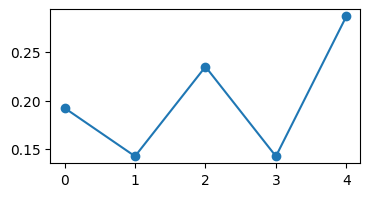

In [70]:
tensor = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)
print(f"{tensor = }")
# Plot the tensor
plt.figure(figsize=(4, 2))
plt.plot(tensor.numpy(), marker='o')

tensor = tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


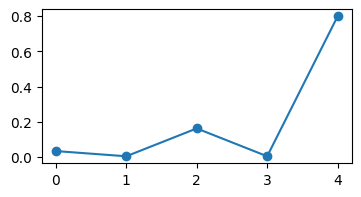

In [71]:
tensor = torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1) # gets too peaky, converges to one-hot
print(f"{tensor = }")
plt.figure(figsize=(4, 2))
plt.plot(tensor.numpy(), marker='o')

## Building the Transformer

We will build the <span style="color:skyblue">***multi-headed self-attention***</span>, which is constructed by simply <span style="color:skyblue">*applying multiple self-attentions in parallel*</span>. We will also learn the <span style="color:skyblue">***feedforward layers of the transformer block***</span> and some optimization tricks to make the network train better (<span style="color:skyblue">***residual connections, layernorm, dropout***</span>) 

In [72]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd = 384, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd = 384, dropout=0.2):
        super().__init__()
        # make multiple heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # run all heads and concat the results into a list over the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

## Notes on Transformer

### Encoder vs. Decoder vs. both (?) Transformer
Below we have the architecture of the Transformer from the "Attention is all you need" paper
<img src="../assets/Transformer.png" width="300" />.

We can see that it has an Encoder (Input Embedding) and a Decoder (Output Embedding). <span style="color:red">***In our code, we only have the Decoder***</span> since we are only generating texts from the input data. 
- The Decoder is made with the triangular mask so it has the auto regressive property where we can just go and sample from it. 
- In the paper, the setting is translating French to English. Hence the Encoder is used to encode the French input texts
- The Encoder does not have the triangular mask since it can see everything from the input texts

## References

- [Let's build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=9&t=957s)
- [Attention is all you need paper](https://arxiv.org/pdf/1706.03762)